In [21]:
import sdm as sdmlib
import matplotlib.pyplot as plt
import time
from collections import defaultdict, OrderedDict
from IPython.display import clear_output
%matplotlib inline

In [15]:
class Timer(object):
    def __init__(self):
        self.stats = OrderedDict()
        self.current_key = None
        
    def start(self, key, name):
        self.current_key = key
        self.stats[key] = {
            'name': name,
            't0_loops': [],
            't0': time.time(),
        }
        self.t0 = time.time()
        
    def measure_loop(self):
        self.stats[self.current_key]['t0_loops'].append(time.time())
        
    def end(self):
        d = self.stats[self.current_key]
        d['dt'] = time.time() - d['t0']
        if d['t0_loops']:
            d['number-of-loops'] = len(d['t0_loops'])
            d['loops-per-second'] = d['number-of-loops'] / d['dt']
            d['loops'] = []
            
            t0 = d['t0']
            for t1 in d['t0_loops']:
                d['loops'].append(t1-t0)
                t0 = t1
        d.pop('t0')
        d.pop('t0_loops')
        self.current_key = None

In [3]:
def run_part1(bits, sample, radius, nlinear=1000, nthread=5000, nopencl=5000):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    address_space.opencl_init();
    
    timer = Timer()

    print('Running linear scan...')
    timer.start('scan_linear', 'Linear scan')
    for i in range(nlinear):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_linear2(bs, radius)
        timer.measure_loop()
    timer.end()

    timer.start('scan_thread', 'Thread scan')
    print('Running thread scan...')
    for i in range(nthread):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_thread2(bs, radius)  
        timer.measure_loop()
    timer.end()
    
    timer.start('scan_opencl', 'OpenCL scan')
    print('Running OpenCL scan...')
    for i in range(nopencl):
        bs = sdmlib.Bitstring.init_random(bits)
        address_space.scan_opencl2(bs, radius)
        timer.measure_loop()
    timer.end()
    
    return timer

In [11]:
def results_part1(bits, timer):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Scans per second', 'Time per scan (ms)']]
    v.append(['---', '---:', '---:', '---:', '---:'])
    for key in ['scan_linear', 'scan_thread', 'scan_opencl']:
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))

    plt.figure(figsize=(8, 6), dpi=300)
    plt.hist([1000*x for x in timer.stats['scan_linear']['loops']], bins='fd', density=True, alpha=0.9, label='Linear scan')
    plt.hist([1000*x for x in timer.stats['scan_thread']['loops']], bins='fd', density=True, alpha=0.9, label='Thread scan')
    plt.hist([1000*x for x in timer.stats['scan_opencl']['loops']], bins='fd', density=True, alpha=0.9, label='OpenCL scan')
    plt.legend()
    plt.title('Scan performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')

In [5]:
timer1000 = run_part1(1000, 1000000, 451)

Running linear scan...
Running thread scan...
Running OpenCL scan...


|Loops|Total time|Scans per second|Time per scan (ms)
---|---:|---:|---:|---:
Linear scan|1000|12.2504069805|81.6299410779|12.2504069805
Thread scan|5000|34.7975389957|143.688322344|6.95950779915
OpenCL scan|5000|21.0078289509|238.006507559|4.20156579018

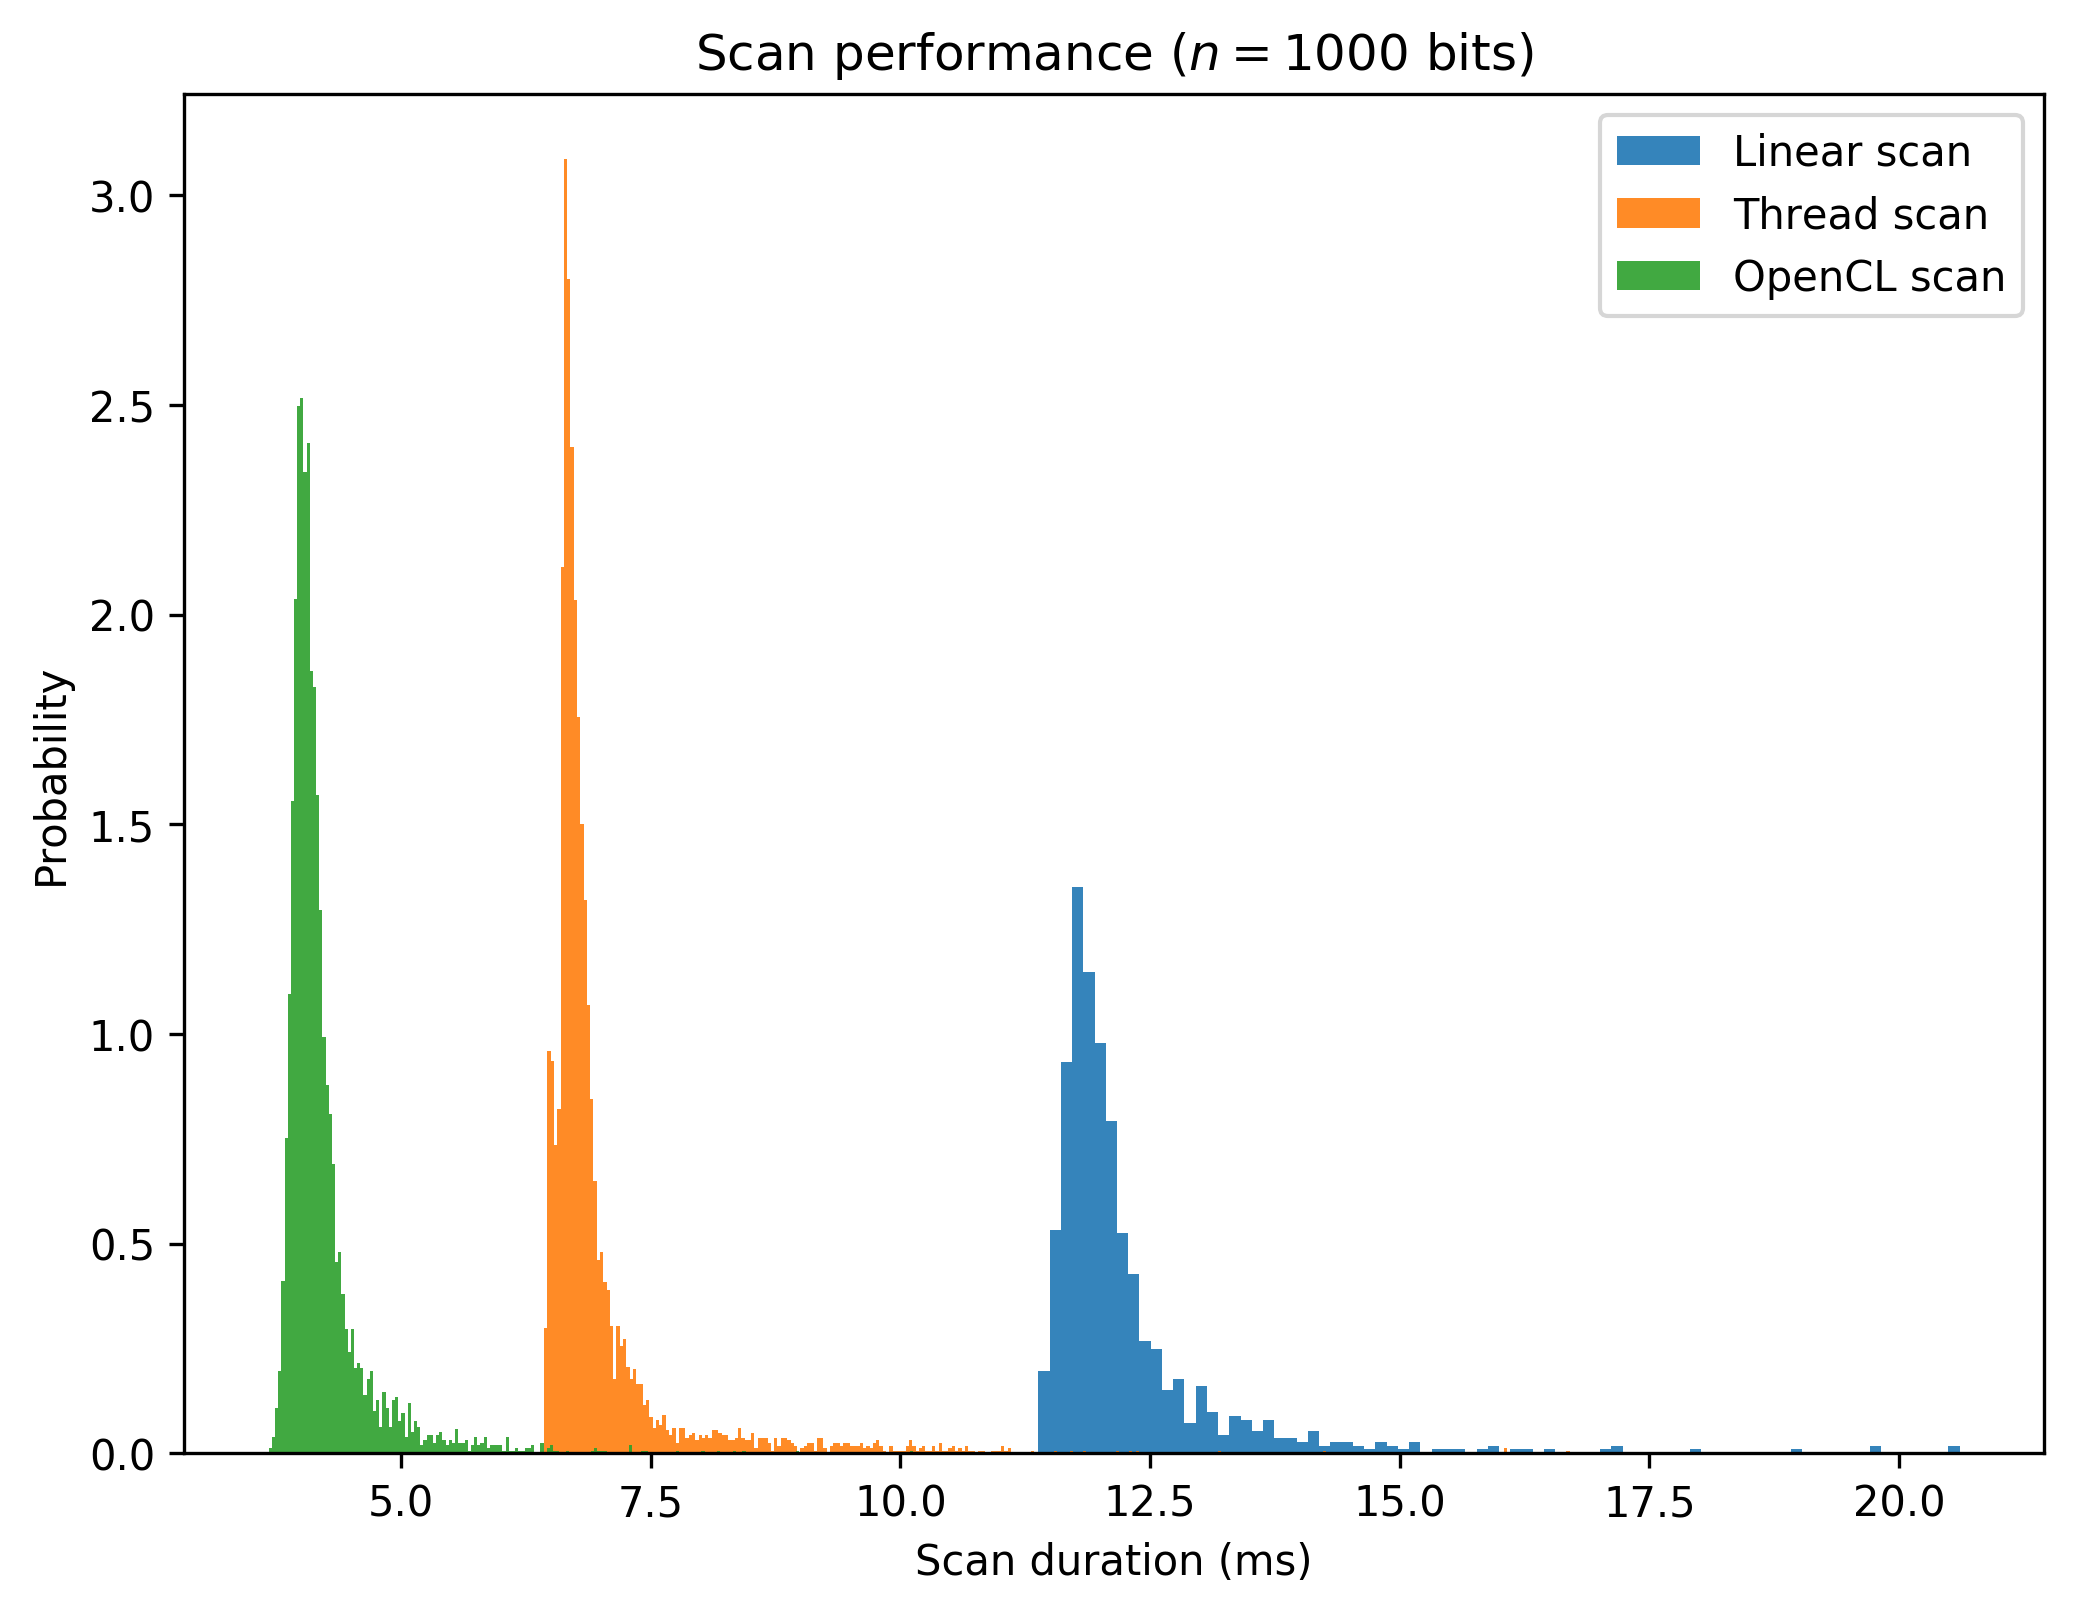

In [12]:
results_part1(1000, timer1000)

In [7]:
timer256 = run_part1(256, 1000000, 103)

Running linear scan...
Running thread scan...
Running OpenCL scan...


|Loops|Total time|Scans per second|Time per scan (ms)
---|---:|---:|---:|---:
Linear scan|1000|5.69847297668|175.48560888|5.69847297668
Thread scan|5000|14.1791188717|352.63122097|2.83582377434
OpenCL scan|5000|20.4173381329|244.88990521|4.08346762657

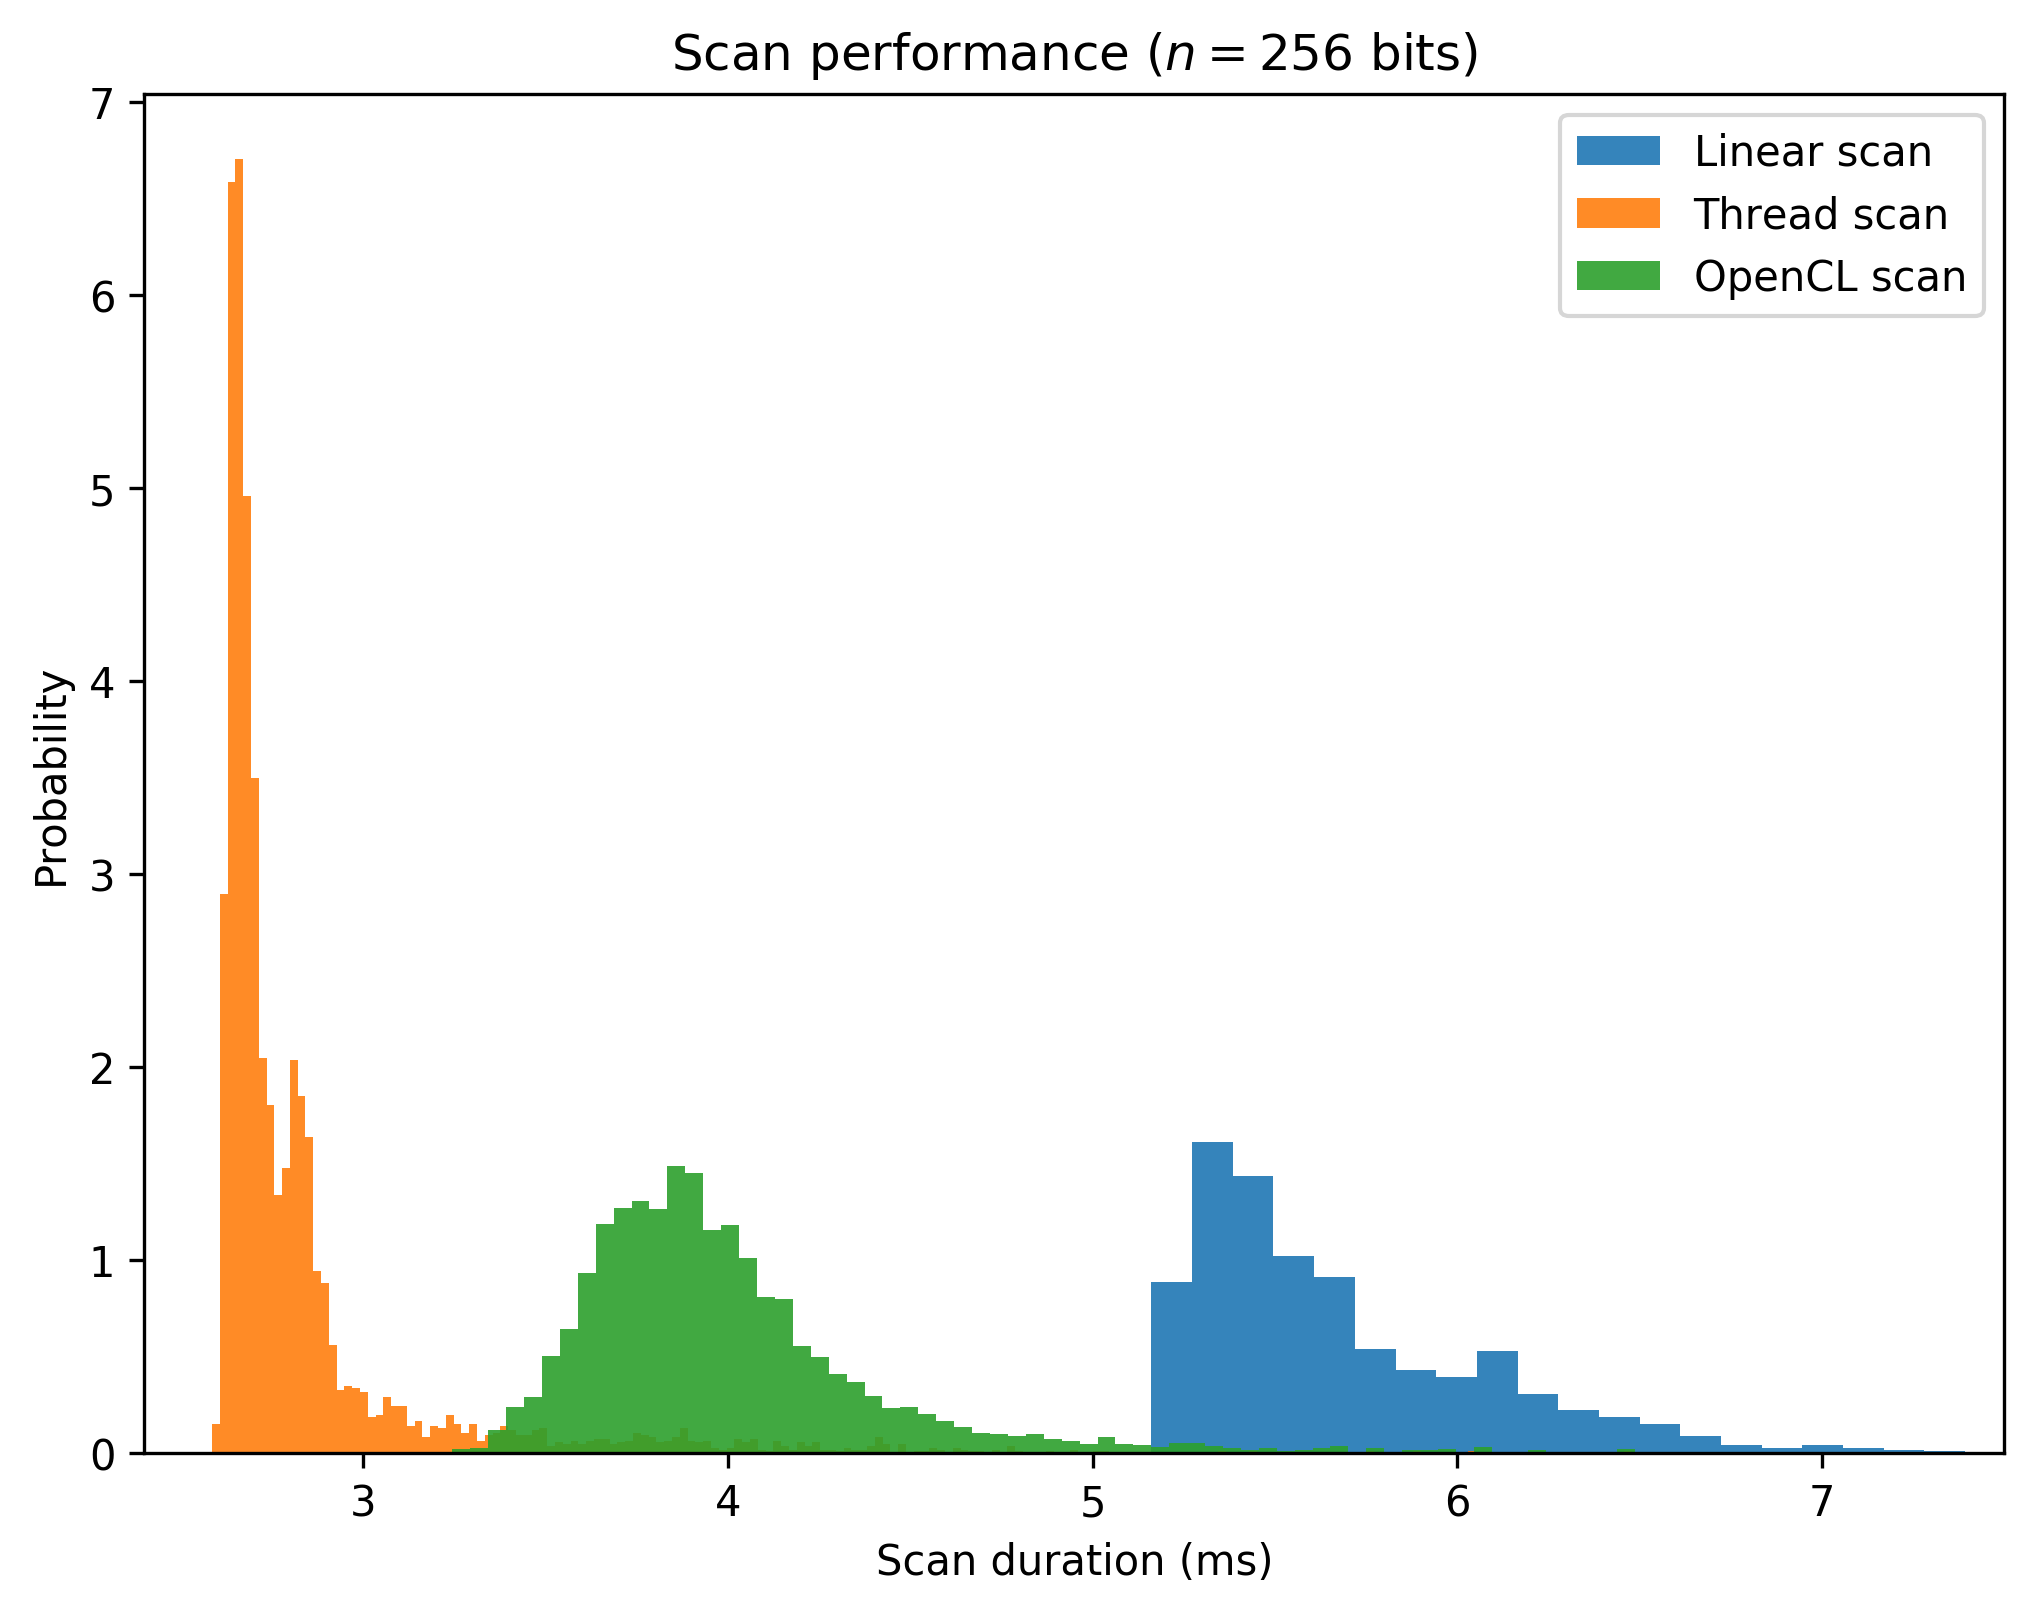

In [13]:
results_part1(256, timer256)
plt.xlim(2.4, 7.5);

In [9]:
timer10k = run_part1(10000, 1000000, 4845, nlinear=100, nthread=500, nopencl=1000)

Running linear scan...
Running thread scan...
Running OpenCL scan...


|Loops|Total time|Scans per second|Time per scan (ms)
---|---:|---:|---:|---:
Linear scan|100|11.6388039589|8.59194813773|116.388039589
Thread scan|500|26.7823820114|18.6689891805|53.5647640228
OpenCL scan|1000|12.952370882|77.2059423798|12.952370882

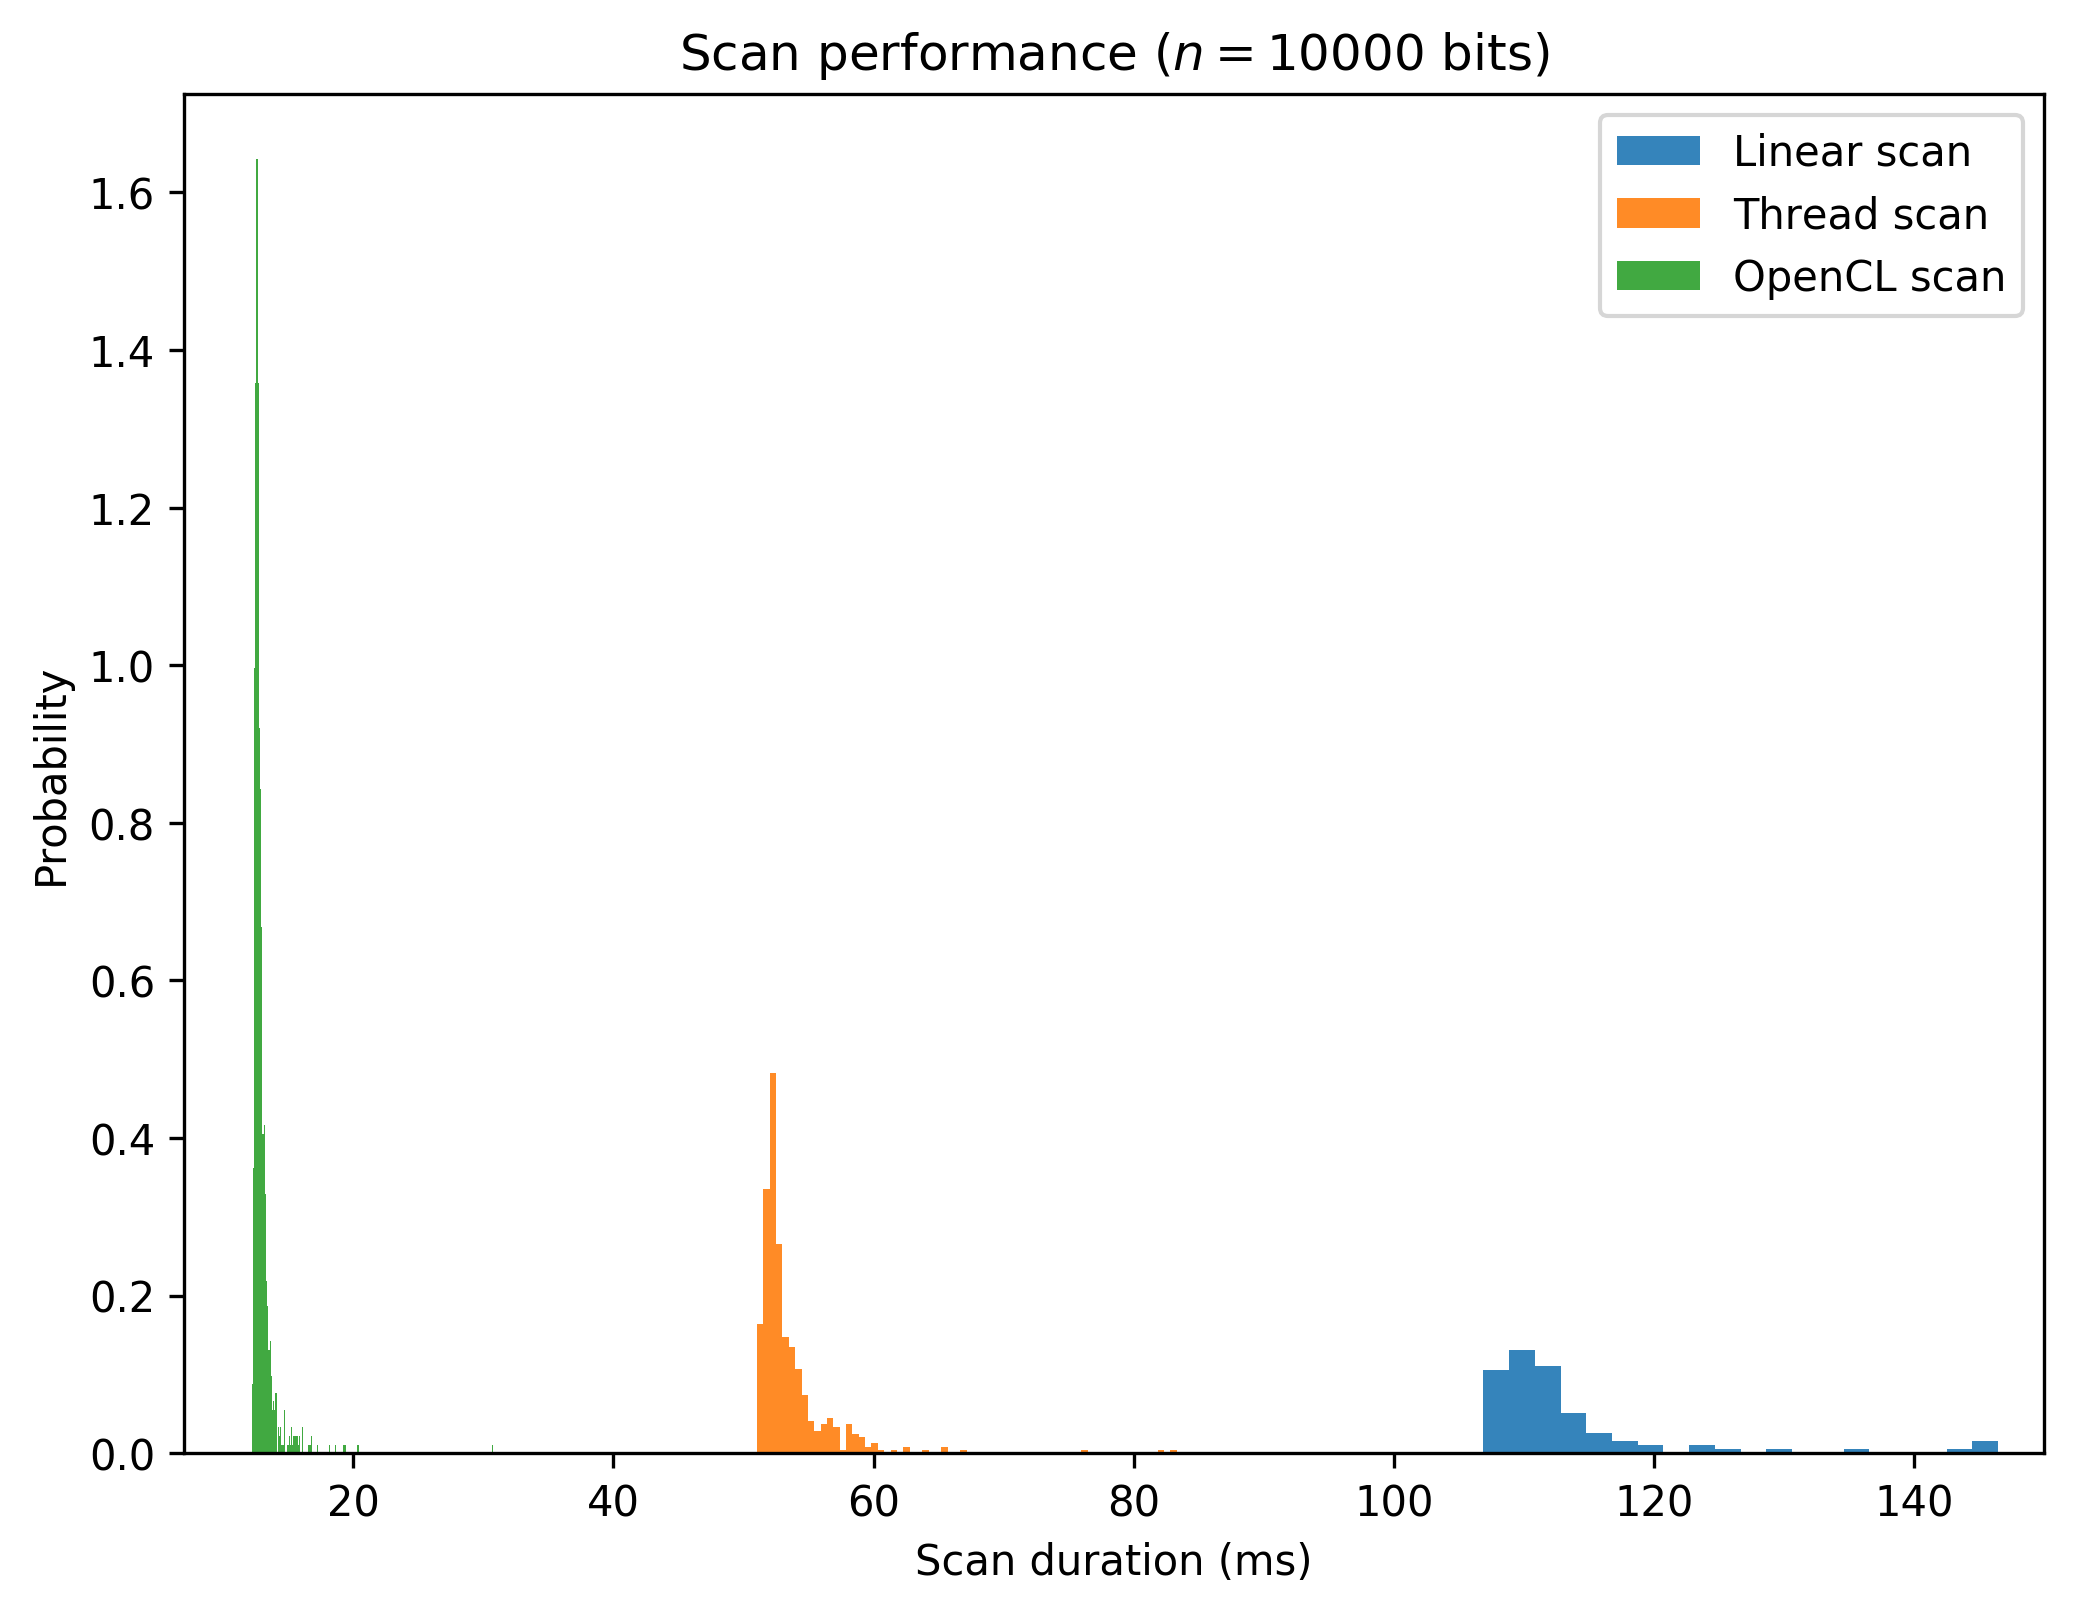

In [14]:
results_part1(10000, timer10k)
plt.xlim(7, 150);

In [18]:
def read_write(key, name, timer, bits, sample, radius, scanner_type, n):
    address_space = sdmlib.AddressSpace.init_random(bits, sample)
    counter = sdmlib.Counter.init_zero(bits, sample)
    sdm = sdmlib.SDM(address_space, counter, radius, scanner_type)

    timer.start('write_{}'.format(key), '{} write'.format(name))
    for _ in range(n):
        bs = sdmlib.Bitstring.init_random(bits)
        sdm.write(bs, bs)
        timer.measure_loop()
    timer.end()
    
    timer.start('read_{}'.format(key), '{} single read'.format(name))
    for _ in range(n):
        bs = sdmlib.Bitstring.init_random(bits)
        sdm.read(bs)
        timer.measure_loop()
    timer.end()
    
    return timer

In [23]:
def run_part2(bits, sample, radius, nthread=1000, nopencl=1000):
    timer = Timer()
    print 'Running thread...'
    read_write('thread', 'Thread', timer, bits, sample, radius, sdmlib.SDM_SCANNER_THREAD, n=nthread)
    print 'Running OpenCL...'
    read_write('opencl', 'OpenCL', timer, bits, sample, radius, sdmlib.SDM_SCANNER_OPENCL, n=nopencl)
    return timer

In [65]:
def results_part2(bits, timer, hist_xlim=None):
    from IPython.display import display, Markdown
    v = [['', 'Loops', 'Total time', 'Operation per second', 'Time per operation (ms)']]
    v.append(['---', '---:', '---:', '---:', '---:'])
    for key in timer.stats.keys():
        stats = timer.stats[key]
        v.append([
            stats['name'],
            stats['number-of-loops'],
            stats['dt'],
            stats['loops-per-second'],
            1000.0 / stats['loops-per-second'],
        ])
    txt = '\n'.join(['|'.join([str(x) for x in row]) for row in v])
    display(Markdown(txt))

    plt.figure(figsize=(8, 6), dpi=300)
    for key in ['write_thread', 'write_opencl']:
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', density=True, alpha=0.9, label=stats['name'])
    plt.legend()
    plt.title('Write performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)
    plt.show()
    
    plt.figure(figsize=(8, 6), dpi=300)
    for key in ['read_thread', 'read_opencl']:
        stats = timer.stats[key]
        plt.hist([1000*x for x in stats['loops']], bins='fd', density=True, alpha=0.9, label=stats['name'])
    plt.legend()
    plt.title('Read performance ($n={}$ bits)'.format(bits))
    plt.xlabel('Scan duration (ms)')
    plt.ylabel('Probability')
    if hist_xlim:
        plt.xlim(*hist_xlim)

In [40]:
p2timer1000 = run_part2(1000, 1000000, 451, nthread=1000, nopencl=1000)

Running thread...
Running OpenCL...


|Loops|Total time|Operation per second|Time per operation (ms)
---|---:|---:|---:|---:
Thread write|1000|13.3464519978|74.9262800457|13.3464519978
Thread single read|1000|10.3919007778|96.228786377|10.3919007778
OpenCL write|1000|7.90451812744|126.509925574|7.90451812744
OpenCL single read|1000|5.25757479668|190.201763869|5.25757479668

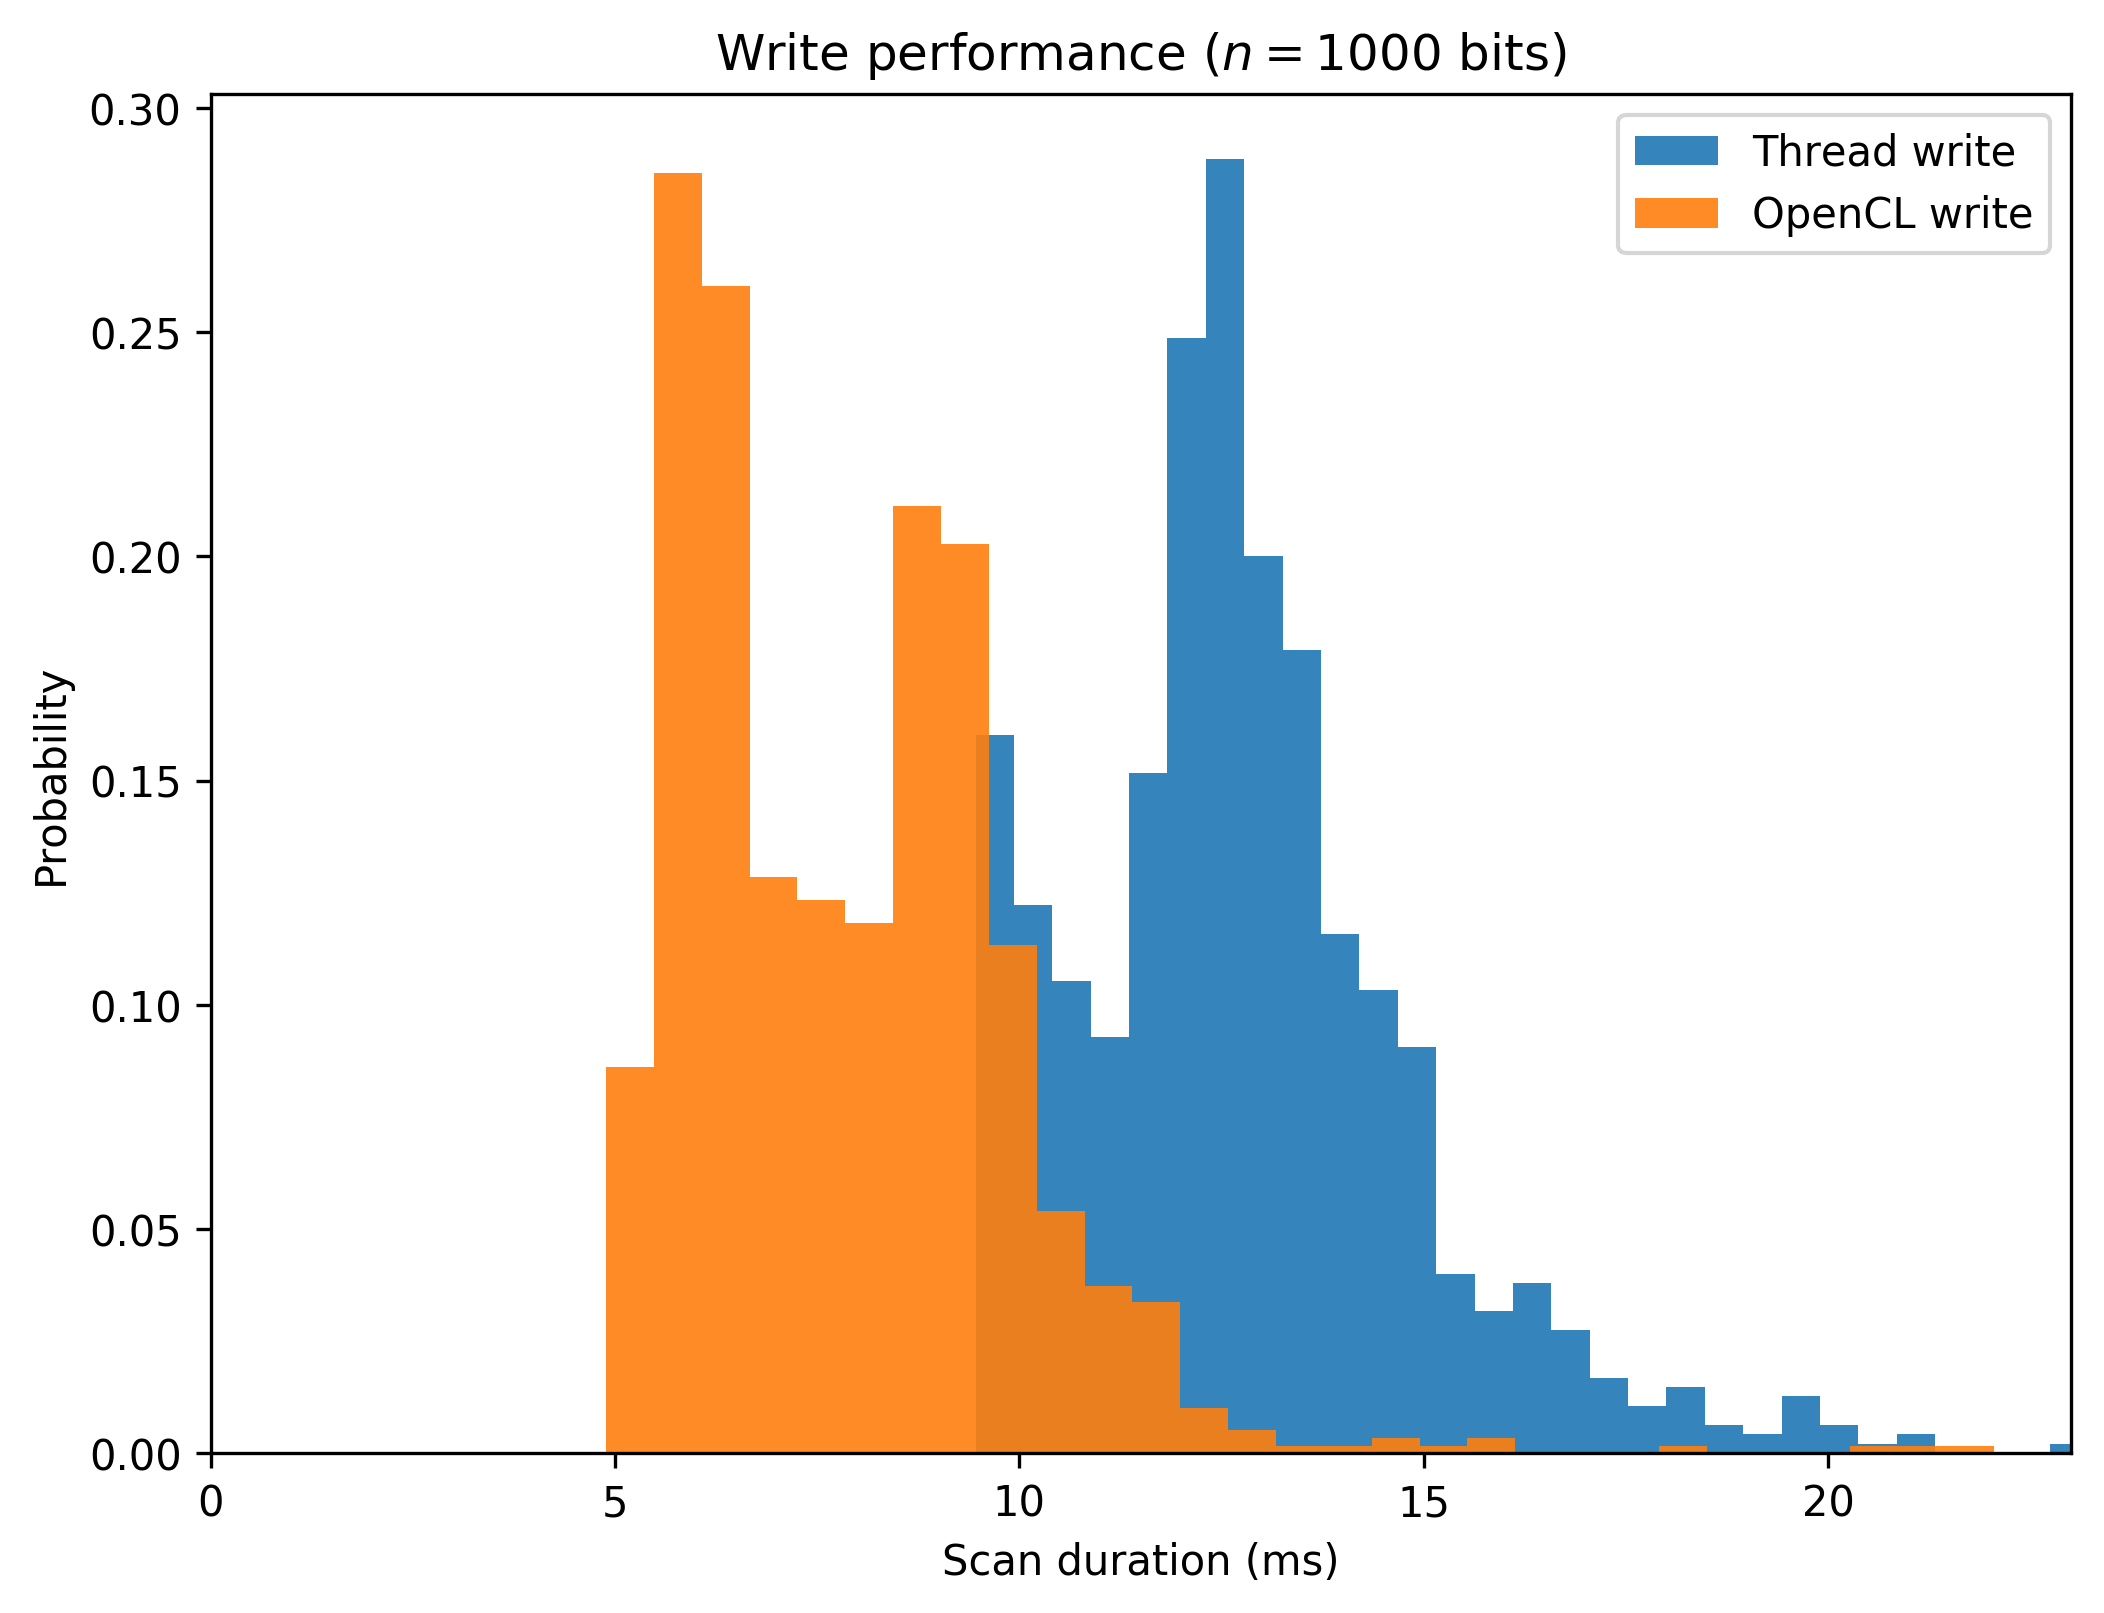

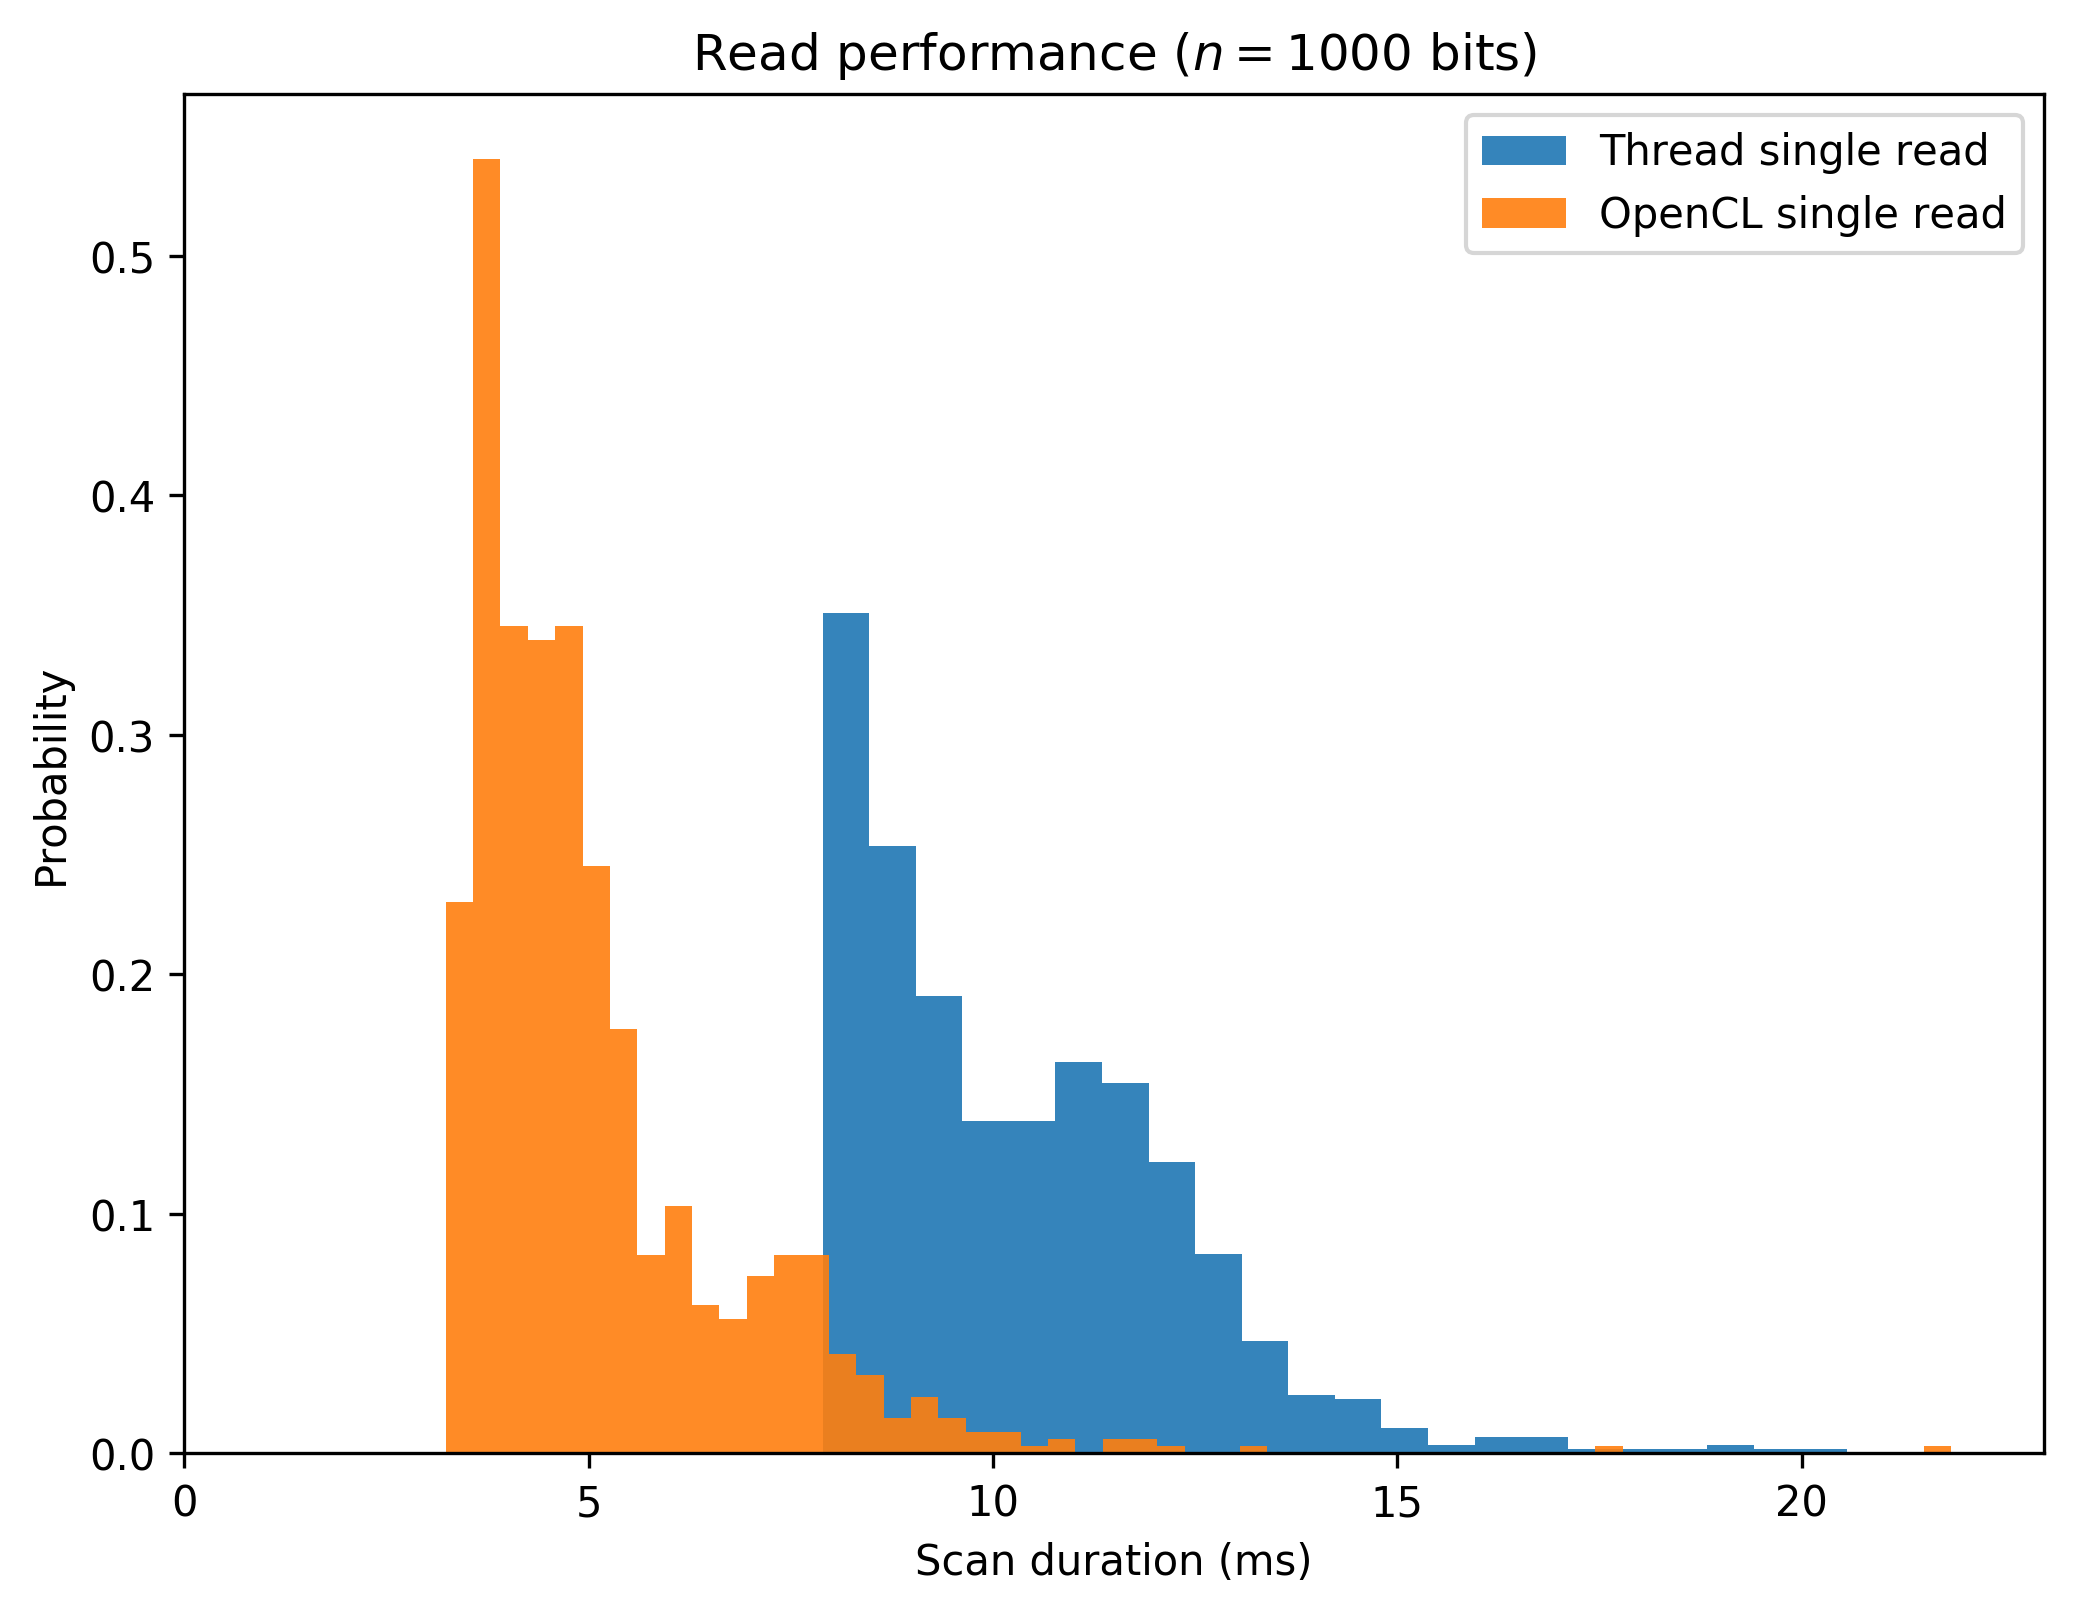

In [67]:
results_part2(1000, p2timer1000, hist_xlim=(0, 23))

In [53]:
p2timer256 = run_part2(256, 1000000, 103, nthread=2000, nopencl=2000)

Running thread...
Running OpenCL...


|Loops|Total time|Operation per second|Time per operation (ms)
---|---:|---:|---:|---:
Thread write|2000|6.56891107559|304.464465569|3.2844555378
Thread single read|2000|5.11222410202|391.219156298|2.55611205101
OpenCL write|2000|5.28474092484|378.448069346|2.64237046242
OpenCL single read|2000|4.29032301903|466.165365901|2.14516150951

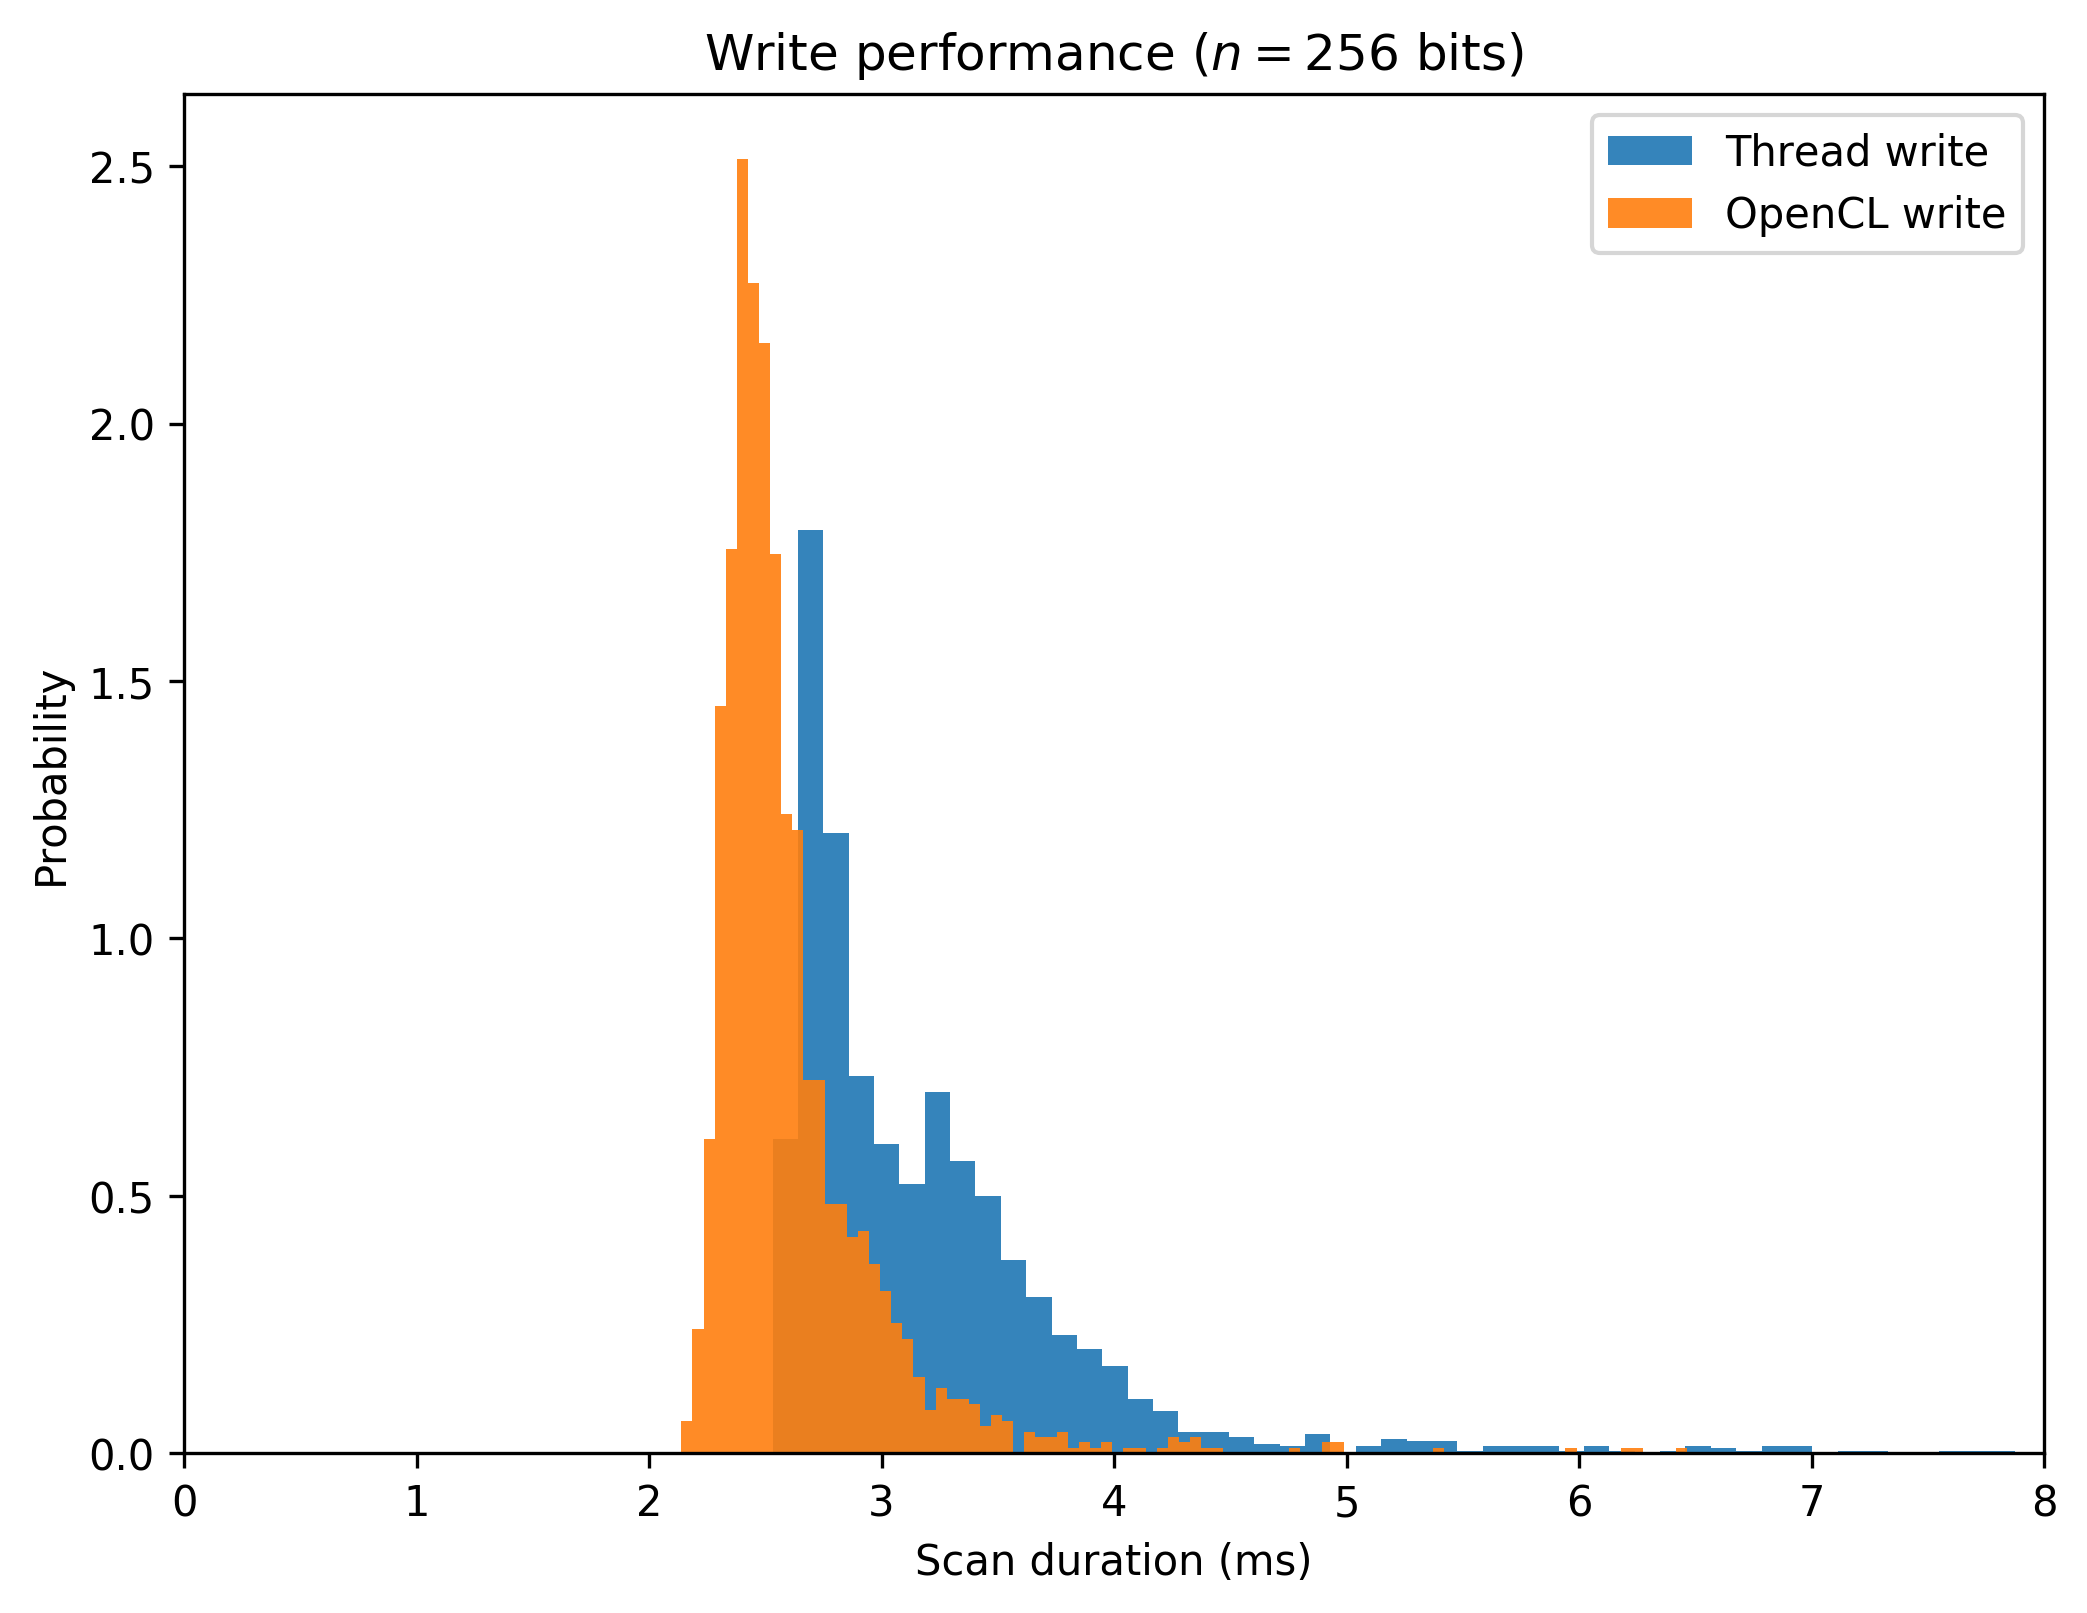

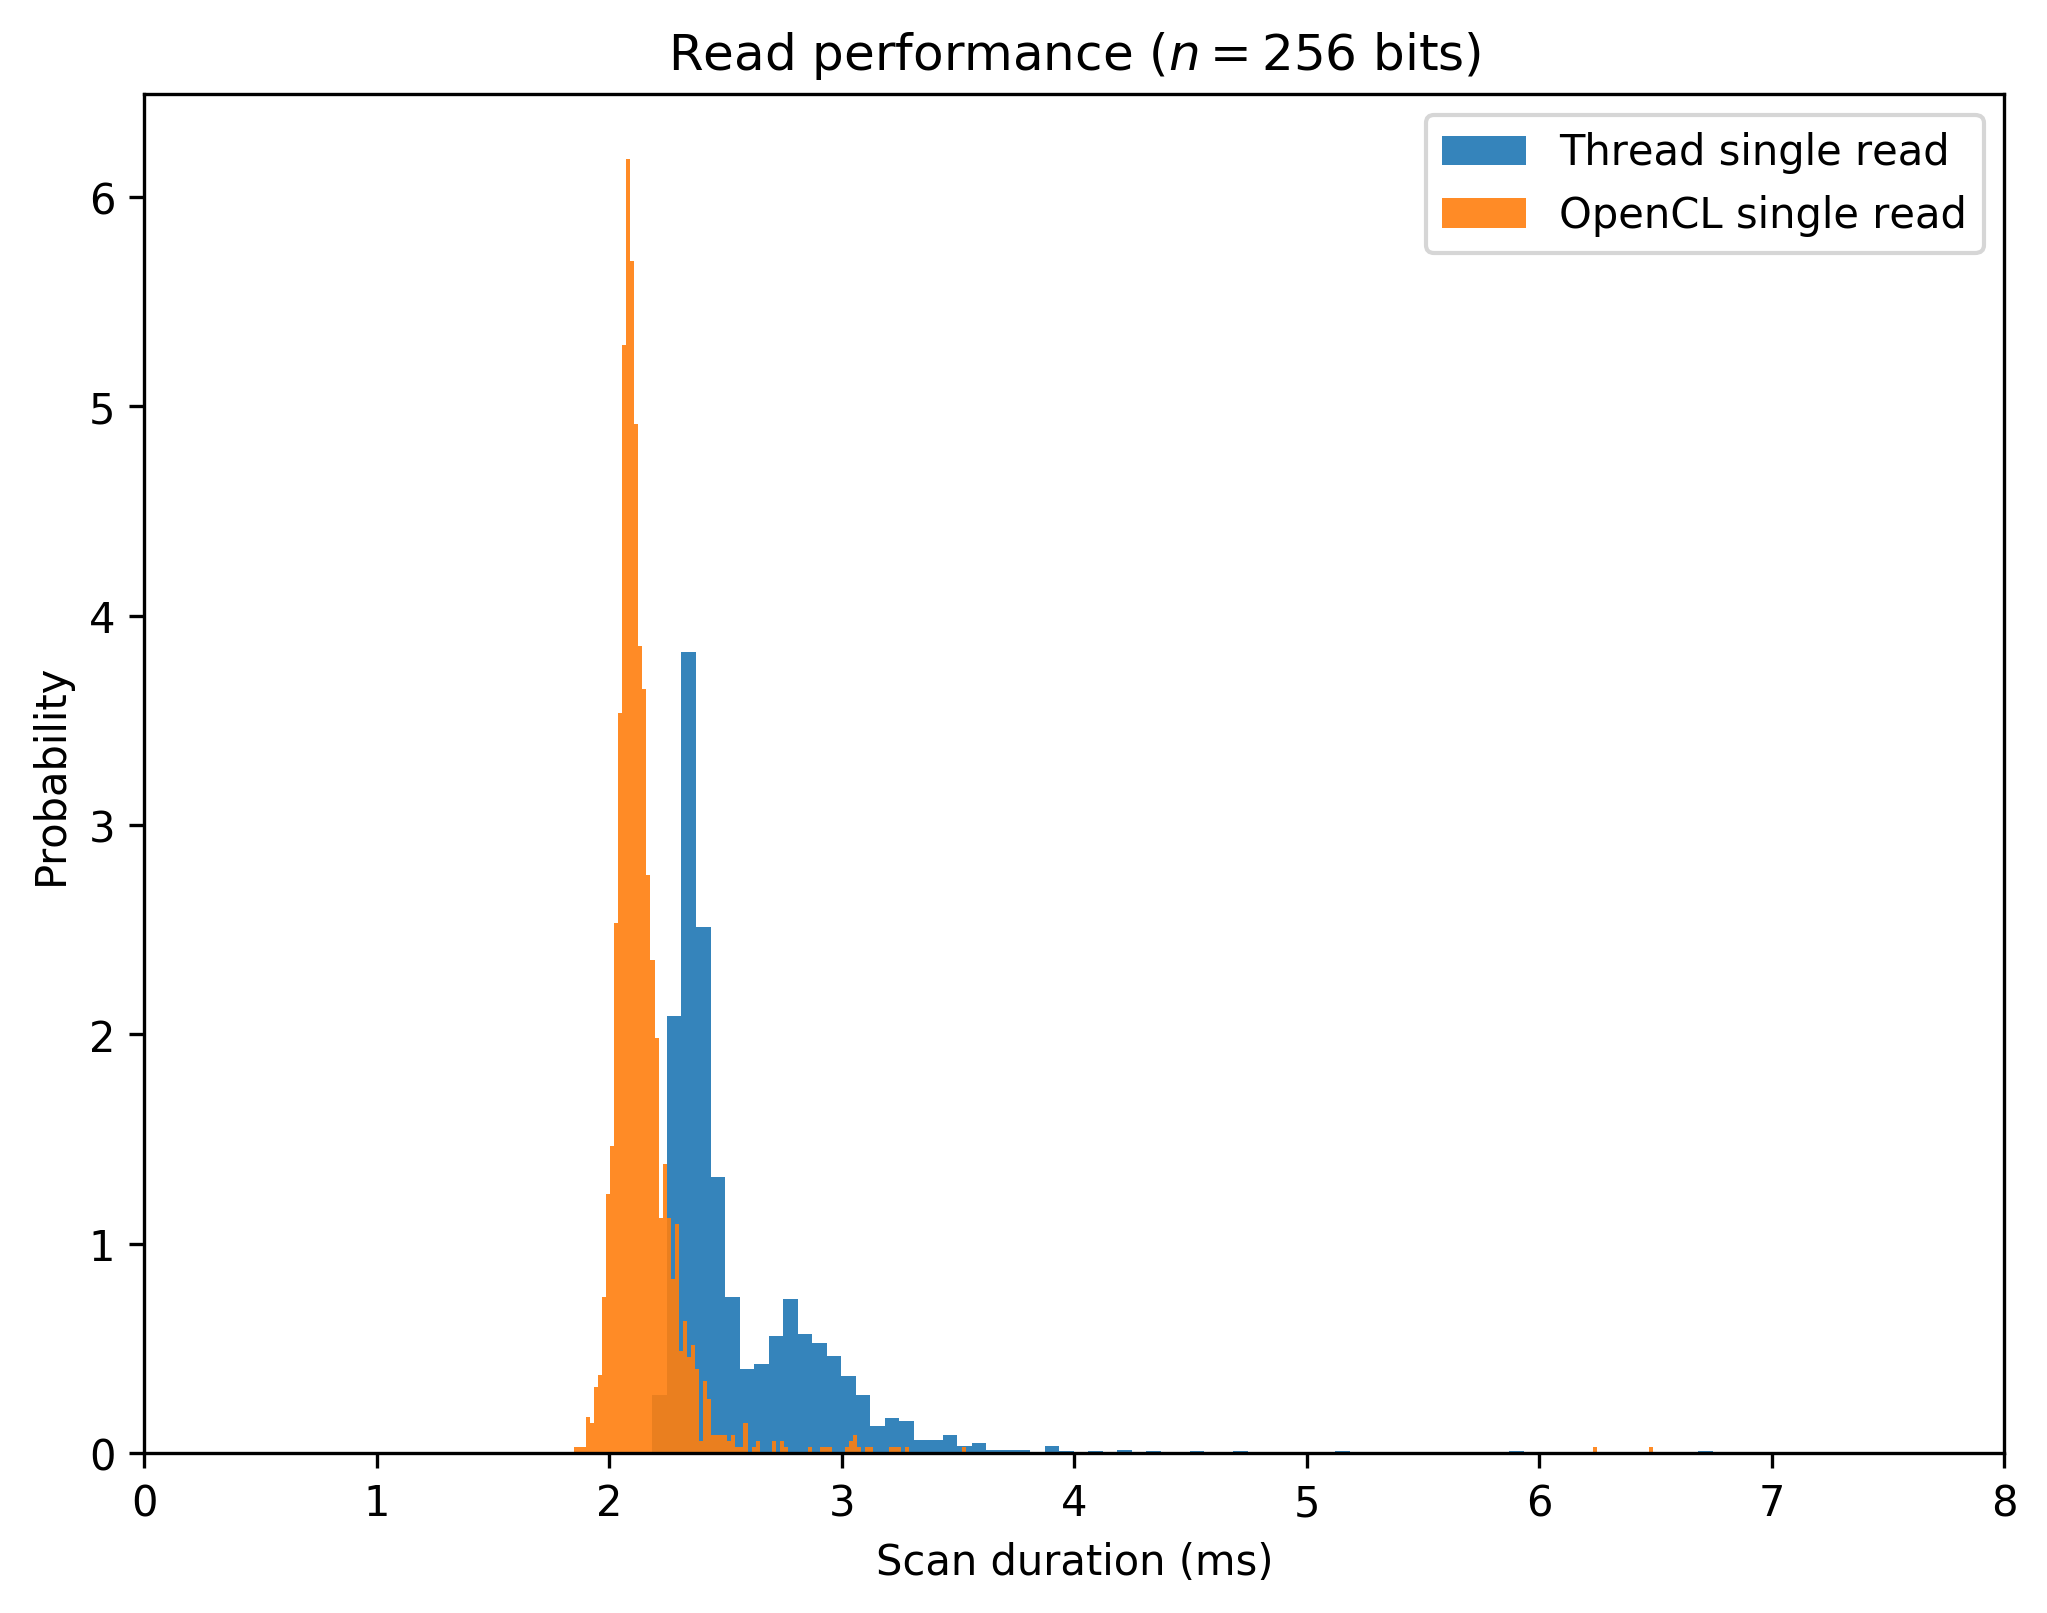

In [61]:
results_part2(256, p2timer256, hist_xlim=(0, 8))

In [ ]:
#p2timer10k = run_part2(10000, 1000000, 4845, nthread=500, nopencl=1000)

Running thread...


In [ ]:
#results_part2(10000, p2timer10k, hist1_xlim=(0, 8), hist2_xlim=(0, 8))